# NE204 Lab 2

## Importing libraries and defining functions

In [287]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from scipy.optimize import curve_fit
from scipy.signal import find_peaks, peak_widths

In [288]:
def ViewPulses(filelocation, events, XRange, beforepulse):
    with h5py.File(filelocation, 'r') as f:
        for a in range(events):
            pulse = np.array(f['raw_data'][a])  # type: ignore
            baseline = np.average(pulse[:beforepulse])
            pulse = pulse - baseline
            plt.plot(range(XRange[0], XRange[1]), pulse[XRange[0]:XRange[1]])
        plt.xlabel("Counts (4 nanoseconds per)")
        plt.ylabel("Units proportional to voltage")

def CreateSpectra(filelocation, events, beforepulse, risetime):
    with h5py.File(filelocation, 'r') as f:
        spectra = []
        for a in range(events):
            pulse = np.array(f['raw_data'][a])  # type: ignore
            baseline = np.average(pulse[:beforepulse])
            pulse = pulse - baseline
            sum = np.sum(pulse[beforepulse:beforepulse+risetime])
            if sum > 0:
                spectra.append(sum)
        return(spectra)

def CreateSpectra_reject(filelocation, events, beforepulse, risetimefast, risetimeslow):
    with h5py.File(filelocation, 'r') as f:
        spectra = []
        a = 0
        rejectedpulses = 0
        while len(spectra) < events:
            pulse = np.array(f['raw_data'][a])  # type: ignore
            a += 1
            baseline = np.average(pulse[:beforepulse])
            pulse = pulse - baseline
            fastsum = np.sum(pulse[beforepulse:beforepulse+risetimefast])
            slowsum = np.sum(pulse[beforepulse+risetimefast:beforepulse+risetimeslow])
            if fastsum > slowsum:
                spectra.append(np.sum(pulse[beforepulse:beforepulse+risetimeslow]))
            else:
                rejectedpulses += 1
        return(spectra, rejectedpulses)

def Gaussian(x, a, b, c, d, e):
    return a*np.exp(-(x-b)**2/(2*c**2))+d*x+e

def InverseRoot(x, a):
    return a/(x**0.5)

def Linear(x, a, b):
    return a*x+b

def PeakInfo(hist, d, promF):
    peaklocations, _ = find_peaks(hist, distance=d, prominence=int(np.amax(hist))/promF)
    widths = peak_widths(hist, peaklocations, rel_height=0.5)
    Xranges = []
    coefficients = []
    numberofpeaks = 0
    FWHMs = []
    for i in range(len(peaklocations)):
        try:
            left = int(peaklocations[i]-widths[0][i])
            right = int(peaklocations[i]+widths[0][i])
            x = np.linspace(left, right, right-left)
            popt, pcov = curve_fit(Gaussian, x, hist[left:right], [hist[peaklocations[i]], peaklocations[i], widths[0][i], 0, 0])
            popt[2] = np.abs(popt[2])
            Xranges.append(x)
            coefficients.append(popt)
            numberofpeaks += 1
            FWHMs.append(widths[0][i])
        except:
            pass
    return Xranges, coefficients, numberofpeaks, FWHMs


Defining the function "Gaussian" as a gaussian plus first order polynomial.

Rise time is counted starting 100 counts before trigger (beforepulse-100).

## Plotting raw raveforms

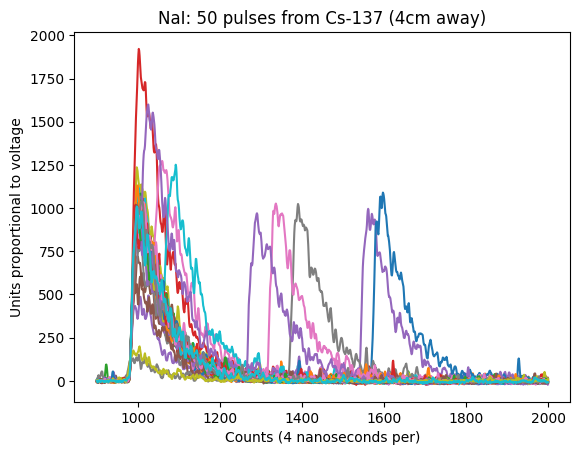

In [289]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Cs137_4cm_30.h5"
events = 50
XRange = (900,2000)
beforepulse = 950
ViewPulses(filelocation, events, XRange, beforepulse)
plt.title('NaI: 50 pulses from Cs-137 (4cm away)')
plt.show()

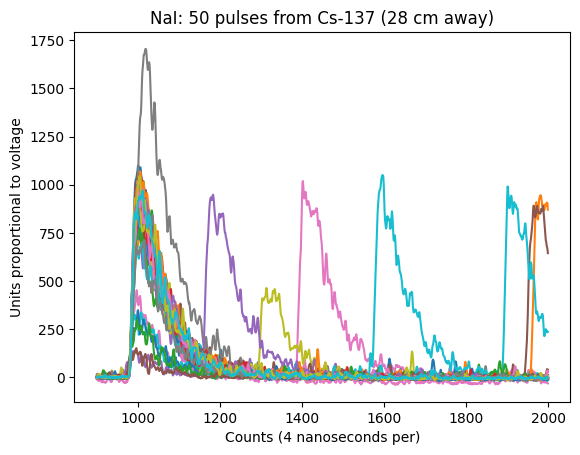

In [290]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Cs137_28cm_30.h5"
events = 50
XRange = (900,2000)
beforepulse = 950
ViewPulses(filelocation, events, XRange, beforepulse)
plt.title('NaI: 50 pulses from Cs-137 (28 cm away)')
plt.show()

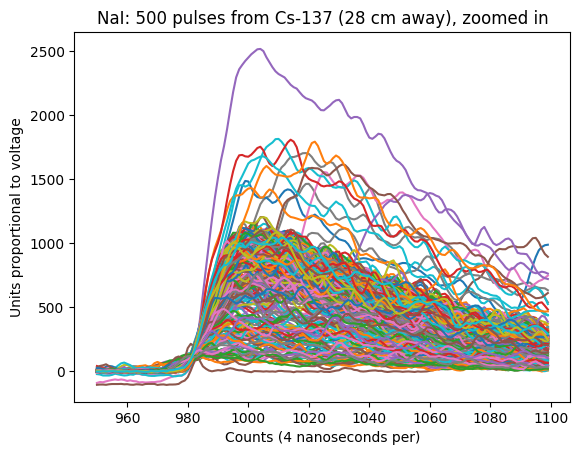

In [291]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Cs137_28cm_30.h5"
events = 500
XRange = (950,1100)
beforepulse = 950
ViewPulses(filelocation, events, XRange, beforepulse)
plt.title('NaI: 500 pulses from Cs-137 (28 cm away), zoomed in')
plt.show()

Also looking at 500 pulses, seems like all pulses start their rise by 970. So setting beforepulse to 970.

The initial pulses generally decay mostly away by about 300 counts after the trigger (1.2 microseconds), so I will use 330 as the initial guess for rise time. Don't see much of a difference in pile-up rate between 4 and 28 cm away however. Noting that since the pulse heights seem to average around 1000, integrating over 330 counts would give pulses that are almost all under 330*1000 = 330000. 

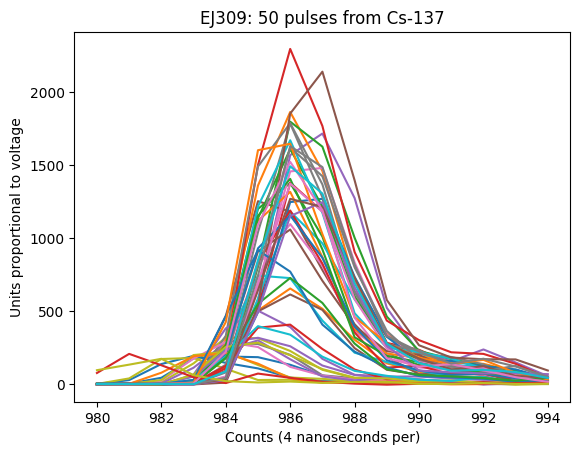

In [292]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\Organic\EJ309_Cs137_60s.h5"
events = 50
XRange = (980,995)
beforepulse = 970
ViewPulses(filelocation, events, XRange, beforepulse)
plt.title('EJ309: 50 pulses from Cs-137')
plt.show()

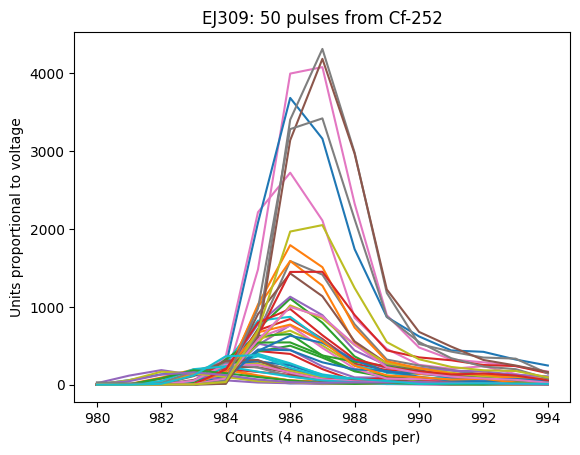

In [293]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\Organic\EJ309_Cf252_60s.h5"
events = 50
XRange = (980,995)
beforepulse = 970
ViewPulses(filelocation, events, XRange, beforepulse)
plt.title('EJ309: 50 pulses from Cf-252')
plt.show()

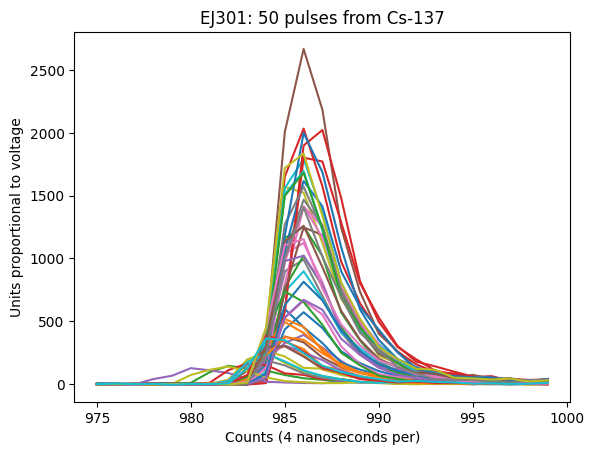

In [294]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\Organic\EJ301_Cs137_60s.h5"
events = 50
XRange = (975,1000)
beforepulse = 970
ViewPulses(filelocation, events, XRange, beforepulse)
plt.title('EJ301: 50 pulses from Cs-137')
plt.show()

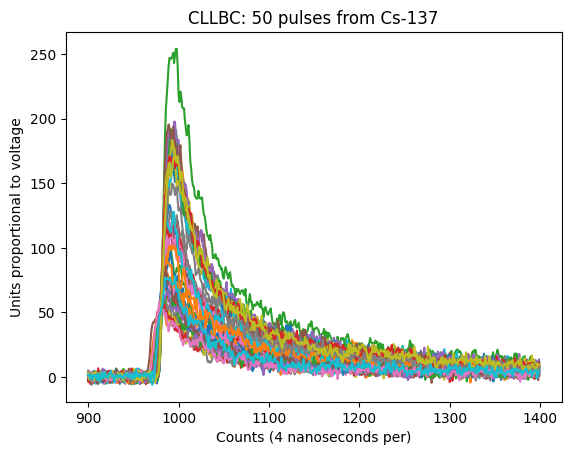

In [295]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\Inorganic\CLLBC_Cs137_180s.h5"
events = 50
XRange = (900,1400)
beforepulse = 970
ViewPulses(filelocation, events, XRange, beforepulse)
plt.title('CLLBC: 50 pulses from Cs-137')
plt.show()

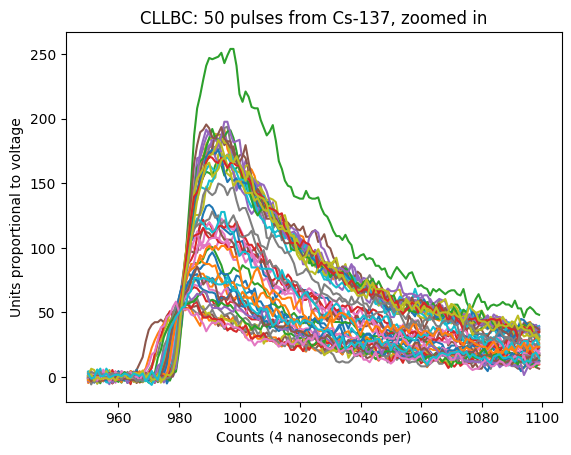

In [296]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\Inorganic\CLLBC_Cs137_180s.h5"
events = 50
XRange = (950,1100)
beforepulse = 970
ViewPulses(filelocation, events, XRange, beforepulse)
plt.title('CLLBC: 50 pulses from Cs-137, zoomed in')
plt.show()

## Analyzing NaI Cs-137 Data to find optimal integration period

1225036.3092783506
Centroid is at: 349.0
FWHM is: 26.41
% Resolution = 7.567


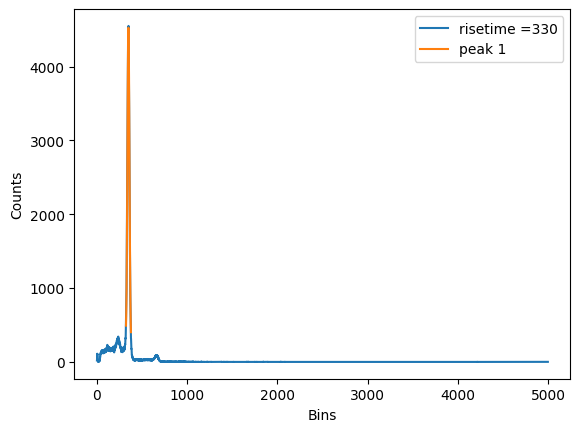

In [303]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Cs137_28cm_30.h5"
events = 200000
beforepulse = 970
peakdistance = 10
prominencefactor = 10
risetime = 330
spectra = CreateSpectra(filelocation, events, beforepulse, risetime)
print(np.max(spectra))
hist, bins = np.histogram(spectra, bins = 5000)
plt.plot(range(np.size(hist)), hist, label="risetime =" + str(risetime))
Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    print("Centroid is at: " + str(coefficients[i][1])[:5])
    print("FWHM is: " + str(2.35*coefficients[i][2])[:5])
    print("% Resolution = " + str(100*2.35*coefficients[i][2]/coefficients[i][1])[:5])
plt.xlabel("Bins")
plt.ylabel("Counts")
plt.legend(loc='upper right')
plt.show()

Seems like the range can be decreased by a factor of six. The maximum of the spectra has a value of ~1,200,000, so will set the spectra range to (0, 200000)

1225036.3092783506
Centroid is at: 427.5
FWHM is: 32.10
% Resolution = 7.508


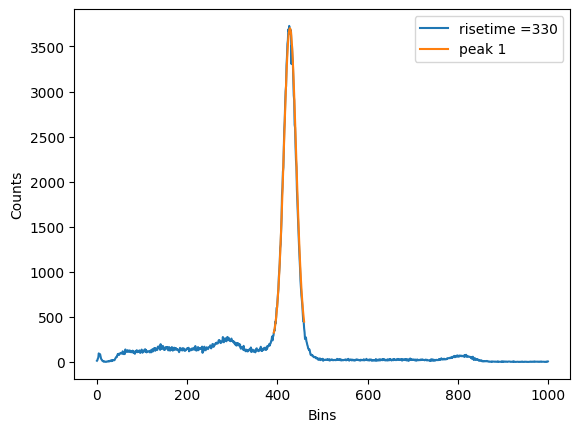

In [304]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Cs137_28cm_30.h5"
events = 200000
beforepulse = 970
peakdistance = 10
prominencefactor = 10
risetime = 330
spectra = CreateSpectra(filelocation, events, beforepulse, risetime)
print(np.max(spectra))
hist, bins = np.histogram(spectra, bins = 1000, range = (0,200000))
plt.plot(range(np.size(hist)), hist, label="risetime =" + str(risetime))
Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    print("Centroid is at: " + str(coefficients[i][1])[:5])
    print("FWHM is: " + str(2.35*coefficients[i][2])[:5])
    print("% Resolution = " + str(100*2.35*coefficients[i][2]/coefficients[i][1])[:5])
plt.xlabel("Bins")
plt.ylabel("Counts")
plt.legend(loc='upper right')
plt.show()

Centroid is at: 303.4
FWHM is: 24.30
% Resolution = 8.008
Centroid is at: 426.9
FWHM is: 31.82
% Resolution = 7.454
Centroid is at: 429.9
FWHM is: 34.03
% Resolution = 7.916


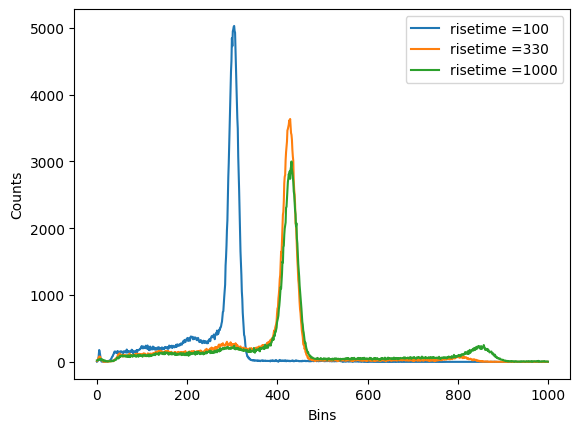

In [309]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Cs137_4cm_30.h5"
risetimes = (100, 330, 1000)

for i in risetimes:
    spectra = CreateSpectra(filelocation, events, beforepulse, i)
    hist, bins = np.histogram(spectra, bins = 1000, range = (0, 200000))
    plt.plot(range(np.size(hist)), hist, label="risetime =" + str(i))
    Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
    for i in range(numberofpeaks):
        #plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
        print("Centroid is at: " + str(coefficients[i][1])[:5])
        print("FWHM is: " + str(2.35*coefficients[i][2])[:5])
        print("% Resolution = " + str(100*2.35*coefficients[i][2]/coefficients[i][1])[:5])

plt.xlabel("Bins")
plt.ylabel("Counts")
plt.legend(loc='upper right')
plt.show()

Centroid is at: 304.4
FWHM is: 24.51
% Resolution = 8.054
Centroid is at: 427.5
FWHM is: 32.10
% Resolution = 7.508
Centroid is at: 429.4
FWHM is: 33.84
% Resolution = 7.881


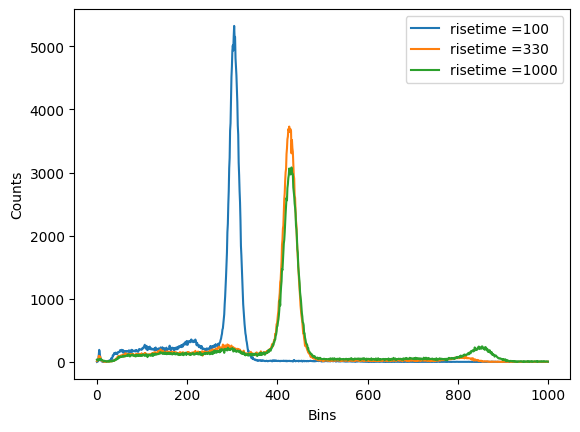

In [308]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Cs137_28cm_30.h5"
risetimes = (100, 330, 1000)

for i in risetimes:
    spectra = CreateSpectra(filelocation, events, beforepulse, i)
    hist, bins = np.histogram(spectra, bins = 1000, range = (0, 200000))
    plt.plot(range(np.size(hist)), hist, label="risetime =" + str(i))
    Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
    for i in range(numberofpeaks):
        #plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
        print("Centroid is at: " + str(coefficients[i][1])[:5])
        print("FWHM is: " + str(2.35*coefficients[i][2])[:5])
        print("% Resolution = " + str(100*2.35*coefficients[i][2]/coefficients[i][1])[:5])

plt.xlabel("Bins")
plt.ylabel("Counts")
plt.legend(loc='upper right')
plt.show()

Comparing integration periods of 200 and 1000 counts, the spectra created from a longer rise time will have a photopeak that shows up further to the right on the graph since more of the pulse is integrated over. Setting the integration period to 1000 shows a second peak at twice the magnitude, due to integrating over two pulses. 

With 1000 bins for a range of 200000, equivalent bin size for a full range of values (up to 1110000) would require ~6000 bins. Will try to find optimal number of bins now.

In [249]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Cs137_28cm_30.h5"

data = []
for a in range(5):
    row = []
    events = 200000
    beforepulse = 970
    prominencefactor = 10
    risetime = 100*(a+2)
    spectra = CreateSpectra(filelocation, events, beforepulse, risetime)
    for b in range(10):
        resolutions = []
        peakdistance = 3*(b+1)
        hist, bins = np.histogram(spectra, bins = 2000*(b+2))
        Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
        for i in range(numberofpeaks):
            resolutions.append(100*2.35*coefficients[i][2]/coefficients[i][1])
        row.append(np.average(resolutions))    
    data.append(row)

df = pd.DataFrame(data, index=100*(np.array(range(5))+2), columns=2000*(np.array(range(10))+2))
df.style.background_gradient(axis=None)



,4000,6000,8000,10000,12000,14000,16000,18000,20000,22000
200,7.702494,7.622711,7.610847,7.598138,7.580664,7.577831,7.565398,7.566189,7.549795,7.554950
300,7.594981,7.526775,7.496490,7.479627,7.458689,7.461299,7.450883,7.442949,7.404919,7.435412
400,7.590465,7.534163,7.513678,7.499743,7.497342,7.473750,7.471225,7.477410,7.446428,7.446763
500,7.620458,7.585013,7.549747,7.511367,7.524873,7.487951,7.499551,7.457229,7.464988,7.473963
600,7.661043,7.627101,7.563606,7.562390,7.563431,7.557291,7.502368,7.508643,7.524446,7.492105


Seems like resolution for the 662 keV photopeak generally gets better with increasing amount of bins

In [250]:
filelocations = [ 
    r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Cs137_4cm_30.h5", 
    r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Cs137_8cm_30.h5", 
    r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Cs137_12cm_30.h5",
    r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Cs137_16cm_30.h5",
    r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Cs137_20cm_30.h5",
    r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Cs137_24cm_30.h5",
    r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Cs137_28cm_30.h5",
    ]

filenames = []
data = []
for a in filelocations:
    row = []
    filelocation = a
    filenames.append(os.path.split(a)[1])
    events = 200000
    beforepulse = 970
    peakdistance = 30
    prominencefactor = 10
    for b in range(10):
        resolutions = []
        risetime = 100*(b+1)
        spectra = CreateSpectra(filelocation, events, beforepulse, risetime)
        hist, bins = np.histogram(spectra, bins = 12000)
        Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
        for i in range(numberofpeaks):
            resolutions.append(100*2.35*coefficients[i][2]/coefficients[i][1])
        row.append(np.average(resolutions))    
    data.append(row)

df = pd.DataFrame(data, index=filenames, columns=100*(np.array(range(10))+1))
df.style.background_gradient(axis=None)



,100,200,300,400,500,600,700,800,900,1000
NaI_Cs137_4cm_30.h5,7.888797,7.472734,7.411330,7.426440,7.468148,7.536265,7.552478,7.614255,7.749706,7.838793
NaI_Cs137_8cm_30.h5,7.937949,7.495410,7.396681,7.450601,7.518570,7.585502,7.648033,7.767383,7.830845,7.898677
NaI_Cs137_12cm_30.h5,7.837823,7.408166,7.361676,7.381980,7.426073,7.441923,7.569899,7.635454,7.702745,7.818357
NaI_Cs137_16cm_30.h5,7.774467,7.443763,7.433094,7.497287,7.519639,7.582700,7.660516,7.745932,7.812707,7.909631
NaI_Cs137_20cm_30.h5,7.895029,7.458358,7.413997,7.366705,7.436400,7.497198,7.624452,7.718810,7.776652,7.779529
NaI_Cs137_24cm_30.h5,8.017781,7.619891,7.500767,7.483254,7.513065,7.544787,7.620219,7.694394,7.758534,7.824133
NaI_Cs137_28cm_30.h5,7.967993,7.580664,7.458689,7.497342,7.524873,7.563431,7.591110,7.708364,7.765219,7.834511


In [251]:
filelocations = [ 
    r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Cs137_4cm_30.h5", 
    r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Cs137_8cm_30.h5", 
    r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Cs137_12cm_30.h5",
    r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Cs137_16cm_30.h5",
    r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Cs137_20cm_30.h5",
    r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Cs137_24cm_30.h5",
    r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Cs137_28cm_30.h5",
    ]

filenames = []
data = []
for a in filelocations:
    row = []
    filelocation = a
    filenames.append(os.path.split(a)[1])
    events = 200000
    beforepulse = 970
    peakdistance = 30
    prominencefactor = 10
    for b in range(11):
        resolutions = []
        risetime = 300+10*(b)
        spectra = CreateSpectra(filelocation, events, beforepulse, risetime)
        hist, bins = np.histogram(spectra, bins = 12000)
        Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
        for i in range(numberofpeaks):
            resolutions.append(100*2.35*coefficients[i][2]/coefficients[i][1])
        row.append(np.average(resolutions))    
    data.append(row)

df = pd.DataFrame(data, index=filenames, columns=300+10*(np.array(range(11))))
df.style.background_gradient(axis=None)



,300,310,320,330,340,350,360,370,380,390,400
NaI_Cs137_4cm_30.h5,7.411330,7.411493,7.400451,7.413200,7.406932,7.416358,7.396562,7.403959,7.419945,7.421700,7.426440
NaI_Cs137_8cm_30.h5,7.396681,7.388333,7.404540,7.412560,7.408176,7.420270,7.433430,7.420746,7.444324,7.430359,7.450601
NaI_Cs137_12cm_30.h5,7.361676,7.357970,7.367799,7.383394,7.387916,7.380420,7.392122,7.390111,7.409610,7.388462,7.381980
NaI_Cs137_16cm_30.h5,7.433094,7.396267,7.397856,7.388809,7.427148,7.459728,7.437211,7.457582,7.483837,7.487637,7.497287
NaI_Cs137_20cm_30.h5,7.413997,7.398578,7.395067,7.400472,7.395689,7.402553,7.393186,7.391692,7.396674,7.407405,7.366705
NaI_Cs137_24cm_30.h5,7.500767,7.463227,7.494462,7.515027,7.467423,7.465527,7.472798,7.490003,7.475479,7.465746,7.483254
NaI_Cs137_28cm_30.h5,7.458689,7.471576,7.453351,7.477529,7.468438,7.443847,7.453361,7.435111,7.454704,7.441582,7.497342


This heatmap of the resolutions of the Cs-137 662 keV peak show that generally, optimal resolution results from integrating the pulse over 300-400 counts, starting from 30 counts before the trigger. A closer scan between 300 and 400 counts shows that 320 counts seems to have best results.

For 200000 events per, this process took 49 minutes.

## Pile up rejection

Modified spectra creation function to calculate the sum of the waveform values between the beforepulse and beforepulse + risetimefast, and compare it to the sum of the waveform values between beforepulse + risetimefast and beforepulse + risetimeslow. If the sum of the values between beforepulse and beforepulse + risetimefast is larger than the sum of the values between the beforepulse risetimeslow, then sums the pulse between beforepulse and risetimeslow and uses that in the spectra. If it is smaller, the pulse is rejected.

Going to use 2000 bins since the range (0, 200000) is about a sixth of the maximum, and we used 12000 bins for the risetime analysis

Centroid is at: 429.9
FWHM is: 34.21
% Resolution = 7.957

Number of rejected pulses = 36773
Percent rejected = 18.3865

Centroid is at: 429.9
FWHM is: 34.03
% Resolution = 7.916

Centroid is at: 853.2
FWHM is: 50.70
% Resolution = 5.942



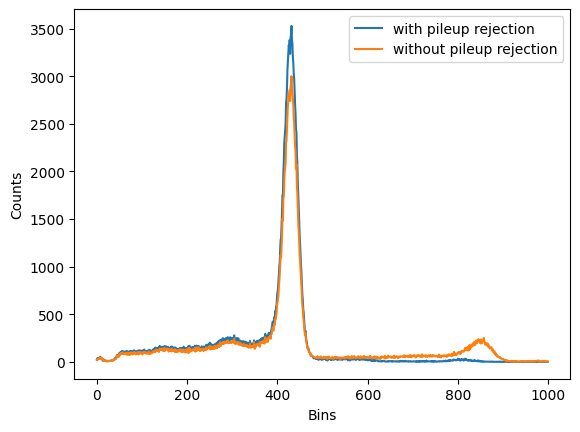

In [344]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Cs137_4cm_30.h5"
risetimefast = 100
risetimeslow = 1000
events = 200000

spectra, rejectedpulses = CreateSpectra_reject(filelocation, events, beforepulse, risetimefast, risetimeslow)
hist, bins = np.histogram(spectra, bins = 1000, range = (0, 200000))
plt.plot(range(np.size(hist)), hist, label="with pileup rejection")
Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    #plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    print("Centroid is at: " + str(coefficients[i][1])[:5])
    print("FWHM is: " + str(2.35*coefficients[i][2])[:5])
    print("% Resolution = " + str(100*2.35*coefficients[i][2]/coefficients[i][1])[:5] + "\n")
print("Number of rejected pulses = " + str(rejectedpulses))
print("Percent rejected = " + str(100*rejectedpulses/events) + "\n")

risetime = 1000

spectra = CreateSpectra(filelocation, events, beforepulse, risetime)
hist, bins = np.histogram(spectra, bins = 1000, range = (0, 200000))
plt.plot(range(np.size(hist)), hist, label="without pileup rejection")
Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    #plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    print("Centroid is at: " + str(coefficients[i][1])[:5])
    print("FWHM is: " + str(2.35*coefficients[i][2])[:5])
    print("% Resolution = " + str(100*2.35*coefficients[i][2]/coefficients[i][1])[:5] + "\n")

plt.xlabel("Bins")
plt.ylabel("Counts")
plt.legend(loc='upper right')
plt.show()

Centroid is at: 426.0
FWHM is: 31.89
% Resolution = 7.485

Number of rejected pulses = 7870
Percent rejected = 3.935

Centroid is at: 426.0
FWHM is: 31.82
% Resolution = 7.469



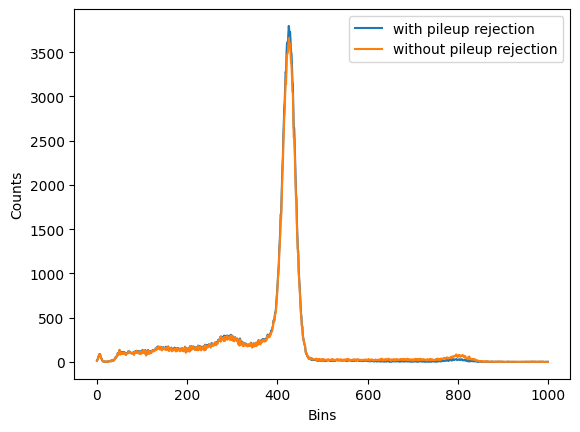

In [345]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Cs137_4cm_30.h5"
risetimefast = 100
risetimeslow = 320

spectra, rejectedpulses = CreateSpectra_reject(filelocation, events, beforepulse, risetimefast, risetimeslow)
hist, bins = np.histogram(spectra, bins = 1000, range = (0, 200000))
plt.plot(range(np.size(hist)), hist, label="with pileup rejection")
Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    #plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    print("Centroid is at: " + str(coefficients[i][1])[:5])
    print("FWHM is: " + str(2.35*coefficients[i][2])[:5])
    print("% Resolution = " + str(100*2.35*coefficients[i][2]/coefficients[i][1])[:5] + "\n")
print("Number of rejected pulses = " + str(rejectedpulses))
print("Percent rejected = " + str(100*rejectedpulses/events) + "\n")

risetime = 320

spectra = CreateSpectra(filelocation, events, beforepulse, risetime)
hist, bins = np.histogram(spectra, bins = 1000, range = (0, 200000))
plt.plot(range(np.size(hist)), hist, label="without pileup rejection")
Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    #plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    print("Centroid is at: " + str(coefficients[i][1])[:5])
    print("FWHM is: " + str(2.35*coefficients[i][2])[:5])
    print("% Resolution = " + str(100*2.35*coefficients[i][2]/coefficients[i][1])[:5] + "\n")

plt.xlabel("Bins")
plt.ylabel("Counts")
plt.legend(loc='upper right')
plt.show()

As we can see above, using the pile-up rejection function has the effect of making the photopeak higher, and removes the small peak at twice the photopeak energy. It rejects about 16% of pulses for summing between 900:1900, and 7% of pulses when summing between 900:1300. However, pile-up rejection does not seem to improve the resolution. Going to repeat this for 28 cm away.

Centroid is at: 429.4
FWHM is: 33.91
% Resolution = 7.897

Number of rejected pulses = 32953
Percent rejected = 16.4765

Centroid is at: 429.4
FWHM is: 33.84
% Resolution = 7.881

Centroid is at: 852.7
FWHM is: 49.73
% Resolution = 5.832



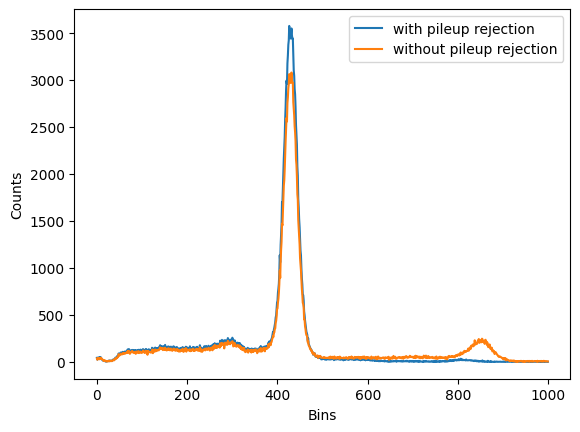

In [346]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Cs137_28cm_30.h5"
risetimefast = 100
risetimeslow = 1000
events = 200000

spectra, rejectedpulses = CreateSpectra_reject(filelocation, events, beforepulse, risetimefast, risetimeslow)
hist, bins = np.histogram(spectra, bins = 1000, range = (0, 200000))
plt.plot(range(np.size(hist)), hist, label="with pileup rejection")
Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    #plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    print("Centroid is at: " + str(coefficients[i][1])[:5])
    print("FWHM is: " + str(2.35*coefficients[i][2])[:5])
    print("% Resolution = " + str(100*2.35*coefficients[i][2]/coefficients[i][1])[:5] + "\n")
print("Number of rejected pulses = " + str(rejectedpulses))
print("Percent rejected = " + str(100*rejectedpulses/events) + "\n")

risetime = 1000

spectra = CreateSpectra(filelocation, events, beforepulse, risetime)
hist, bins = np.histogram(spectra, bins = 1000, range = (0, 200000))
plt.plot(range(np.size(hist)), hist, label="without pileup rejection")
Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    #plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    print("Centroid is at: " + str(coefficients[i][1])[:5])
    print("FWHM is: " + str(2.35*coefficients[i][2])[:5])
    print("% Resolution = " + str(100*2.35*coefficients[i][2]/coefficients[i][1])[:5] + "\n")

plt.xlabel("Bins")
plt.ylabel("Counts")
plt.legend(loc='upper right')
plt.show()

Centroid is at: 426.7
FWHM is: 32.00
% Resolution = 7.501

Number of rejected pulses = 7193
Percent rejected = 3.5965

Centroid is at: 426.7
FWHM is: 32.01
% Resolution = 7.501



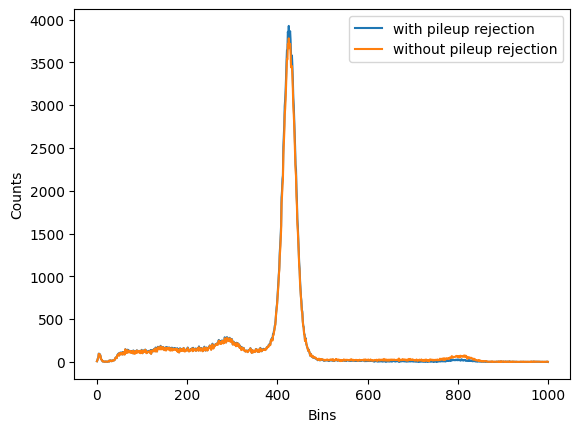

In [347]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Cs137_28cm_30.h5"
risetimefast = 100
risetimeslow = 320

spectra, rejectedpulses = CreateSpectra_reject(filelocation, events, beforepulse, risetimefast, risetimeslow)
hist, bins = np.histogram(spectra, bins = 1000, range = (0, 200000))
plt.plot(range(np.size(hist)), hist, label="with pileup rejection")
Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    #plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    print("Centroid is at: " + str(coefficients[i][1])[:5])
    print("FWHM is: " + str(2.35*coefficients[i][2])[:5])
    print("% Resolution = " + str(100*2.35*coefficients[i][2]/coefficients[i][1])[:5] + "\n")
print("Number of rejected pulses = " + str(rejectedpulses))
print("Percent rejected = " + str(100*rejectedpulses/events) + "\n")

risetime = 320

spectra = CreateSpectra(filelocation, events, beforepulse, risetime)
hist, bins = np.histogram(spectra, bins = 1000, range = (0, 200000))
plt.plot(range(np.size(hist)), hist, label="without pileup rejection")
Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    #plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    print("Centroid is at: " + str(coefficients[i][1])[:5])
    print("FWHM is: " + str(2.35*coefficients[i][2])[:5])
    print("% Resolution = " + str(100*2.35*coefficients[i][2]/coefficients[i][1])[:5] + "\n")

plt.xlabel("Bins")
plt.ylabel("Counts")
plt.legend(loc='upper right')
plt.show()

## Measuring energy resolutions

In [348]:
total_peakinfo = []
energies = []

Will add to this list to create energy calibration

Centroid is at: 622.0
FWHM is: 34.75
% Resolution = 5.587
Centroid is at: 693.8
FWHM is: 35.18
% Resolution = 5.070


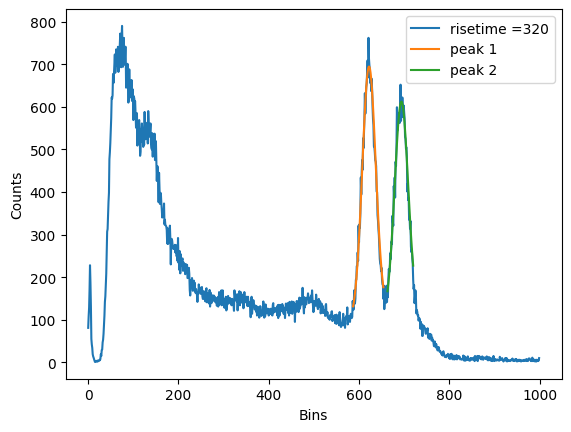

In [349]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Co60_120s.h5"
risetime = 320
peakdistance = 30
prominencefactor = 5
peakinfo = []

spectra = CreateSpectra(filelocation, events, beforepulse, risetime)
hist, bins = np.histogram(spectra, bins = 1000, range = (0, 200000))
plt.plot(range(np.size(hist)), hist, label="risetime =" + str(risetime))
Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    peakinfo.append([coefficients[i][1], 100*2.35*coefficients[i][2]/coefficients[i][1]])
    print("Centroid is at: " + str(coefficients[i][1])[:5])
    print("FWHM is: " + str(2.35*coefficients[i][2])[:5])
    print("% Resolution = " + str(100*2.35*coefficients[i][2]/coefficients[i][1])[:5])

plt.xlabel("Bins")
plt.ylabel("Counts")
plt.legend(loc='upper right')
plt.show()

In [350]:
print(peakinfo)
total_peakinfo.extend(peakinfo)
energies.extend([1173.2, 1332.5])

[[622.0987577288008, 5.5870932418737755], [693.8898622081608, 5.070611462834303]]


Centroid is at: 30.58
FWHM is: 8.606
% Resolution = 28.13
Centroid is at: 81.25
FWHM is: 11.06
% Resolution = 13.61
Centroid is at: 153.8
FWHM is: 16.99
% Resolution = 11.04
Centroid is at: 210.5
FWHM is: 21.23
% Resolution = 10.08
Centroid is at: 441.7
FWHM is: 32.73
% Resolution = 7.410
Centroid is at: 530.5
FWHM is: 28.00
% Resolution = 5.278
Centroid is at: 595.5
FWHM is: 34.15
% Resolution = 5.736
Centroid is at: 736.4
FWHM is: 42.19
% Resolution = 5.729


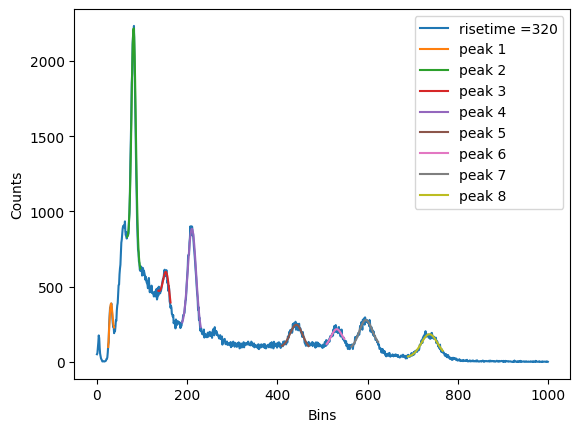

In [351]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Eu152_120s.h5"
prominencefactor = 20
peakinfo = []

spectra = CreateSpectra(filelocation, events, beforepulse, risetime)
hist, bins = np.histogram(spectra, bins = 1000, range = (0,200000))
plt.plot(range(np.size(hist)), hist, label="risetime =" + str(risetime))
Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    peakinfo.append([coefficients[i][1], 100*2.35*coefficients[i][2]/coefficients[i][1]])
    print("Centroid is at: " + str(coefficients[i][1])[:5])
    print("FWHM is: " + str(2.35*coefficients[i][2])[:5])
    print("% Resolution = " + str(100*2.35*coefficients[i][2]/coefficients[i][1])[:5])

plt.xlabel("Bins")
plt.ylabel("Counts")
plt.legend(loc='upper right')
plt.show()

Not including first peak

In [352]:
print(peakinfo[1:])
total_peakinfo.extend(peakinfo[1:])
energies.extend([121.8, 244.7, 344.3, 778.9, 964.1, 1112.1, 1408])

[[81.257190381404, 13.613930737148447], [153.80361211879531, 11.048895670022327], [210.55500294488075, 10.084982114086099], [441.7318189823955, 7.410364868830059], [530.5957057178992, 5.278110732582871], [595.5122964839786, 5.736198953714306], [736.4398488336949, 5.729037167755715]]


Centroid is at: 72.88
FWHM is: 154.1
% Resolution = 211.5
Centroid is at: 301.6
FWHM is: 26.18
% Resolution = 8.680
Centroid is at: 675.2
FWHM is: 38.72
% Resolution = 5.734


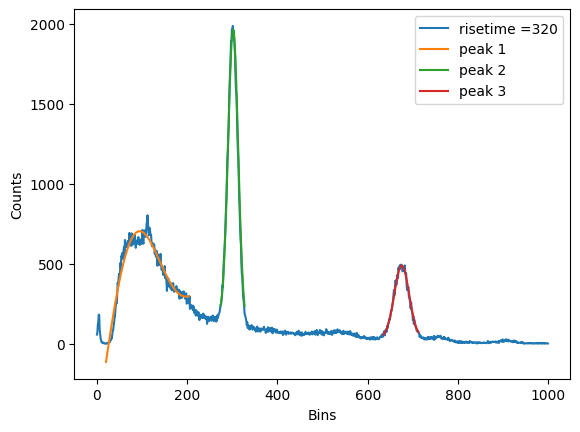

In [353]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Na22_120s.h5"
prominencefactor = 10
peakinfo = []

spectra = CreateSpectra(filelocation, events, beforepulse, risetime)
hist, bins = np.histogram(spectra, bins = 1000, range = (0,200000))
plt.plot(range(np.size(hist)), hist, label="risetime =" + str(risetime))
Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    peakinfo.append([coefficients[i][1], 100*2.35*coefficients[i][2]/coefficients[i][1]])
    print("Centroid is at: " + str(coefficients[i][1])[:5])
    print("FWHM is: " + str(2.35*coefficients[i][2])[:5])
    print("% Resolution = " + str(100*2.35*coefficients[i][2]/coefficients[i][1])[:5])

plt.xlabel("Bins")
plt.ylabel("Counts")
plt.legend(loc='upper right')
plt.show()

Will not add peaks 1 and 2 to list (511 keV peak should not be used)

In [354]:
print(peakinfo[2:])
total_peakinfo.extend(peakinfo[2:])
energies.extend([1274.5])

[[675.2233972099126, 5.734614977502607]]


Centroid is at: 55.59
FWHM is: 9.672
% Resolution = 17.39
Centroid is at: 100.2
FWHM is: 22.44
% Resolution = 22.39
Centroid is at: 183.6
FWHM is: 14.96
% Resolution = 8.148
Centroid is at: 216.4
FWHM is: 20.62
% Resolution = 9.531


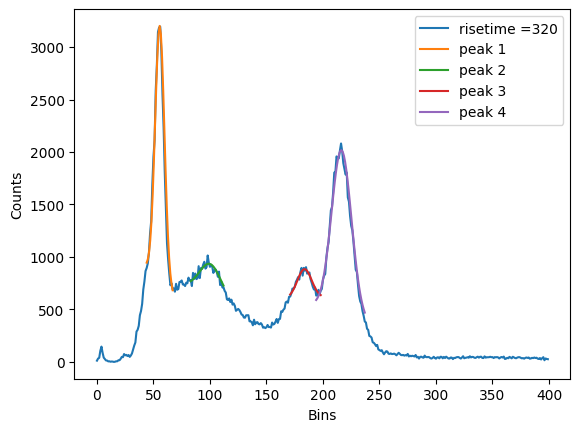

In [355]:
filelocation = r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Ba133_120s.h5"
prominencefactor = 15
peakinfo = []

spectra = CreateSpectra(filelocation, events, beforepulse, risetime)
hist, bins = np.histogram(spectra, bins = 400, range = (0,80000))
plt.plot(range(np.size(hist)), hist, label="risetime =" + str(risetime))
Xranges, coefficients, numberofpeaks, FWHMs = PeakInfo(hist, peakdistance, prominencefactor)
for i in range(numberofpeaks):
    plt.plot(Xranges[i], Gaussian(Xranges[i], *coefficients[i]), label="peak " + str(i+1))
    peakinfo.append([coefficients[i][1], 100*2.35*coefficients[i][2]/coefficients[i][1]])
    print("Centroid is at: " + str(coefficients[i][1])[:5])
    print("FWHM is: " + str(2.35*coefficients[i][2])[:5])
    print("% Resolution = " + str(100*2.35*coefficients[i][2]/coefficients[i][1])[:5])

plt.xlabel("Bins")
plt.ylabel("Counts")
plt.legend(loc='upper right')
plt.show()

I don't believe the second peak is a gamma peak

In [356]:
del peakinfo[1]
print(peakinfo)
total_peakinfo.extend(peakinfo)
energies.extend([81, 302, 356])

[[55.592463028676136, 17.399290158667515], [183.64436199362092, 8.148683932956187], [216.4100251780087, 9.531230685809096]]


y = 1.966*x + -56.0


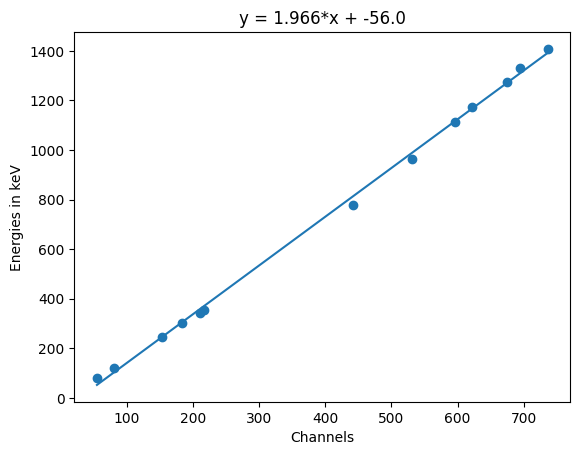

In [367]:
all_peaks = np.array(total_peakinfo)[:,0]
plt.scatter(all_peaks, energies)
popt, pcov = curve_fit(Linear, np.array(total_peakinfo)[:,0], energies)
print("y = "+str(popt[0])[:5]+"*x + "+str(popt[1])[:5])
x = np.linspace(int(np.min(all_peaks)), int(np.max(all_peaks)), int(np.max(all_peaks)-np.min(all_peaks)))
vLinear = np.vectorize(Linear)
all_energies = vLinear(all_peaks, *popt)
plt.plot(x, Linear(x, *popt))
plt.xlabel("Channels")
plt.ylabel("Energies in keV")
plt.title("y = "+str(popt[0])[:5]+"*x + "+str(popt[1])[:5])
plt.show()

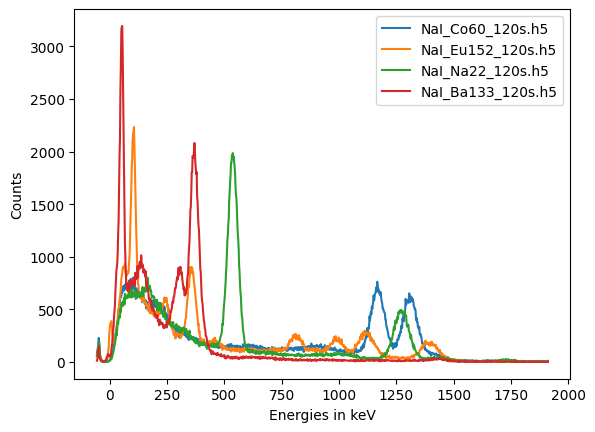

In [358]:
filelocations = [
                r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Co60_120s.h5",
                r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Eu152_120s.h5",
                r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Na22_120s.h5",
                r"C:\Users\devth\Documents\NE204Offline\Inorganic\NaI_Ba133_120s.h5"
                ]

calibratedrange = vLinear(np.linspace(0,1000,1000), *popt)
risetime = 320
for i in filelocations:                
    spectra = CreateSpectra(i, events, beforepulse, risetime)
    hist, bins = np.histogram(spectra, bins = 1000, range = (0,200000))    
    plt.plot(calibratedrange, hist, label=os.path.split(i)[1])

plt.legend(loc='upper right')
plt.xlabel("Energies in keV")
plt.ylabel("Counts")
plt.show()

y = 150.2/x**0.5


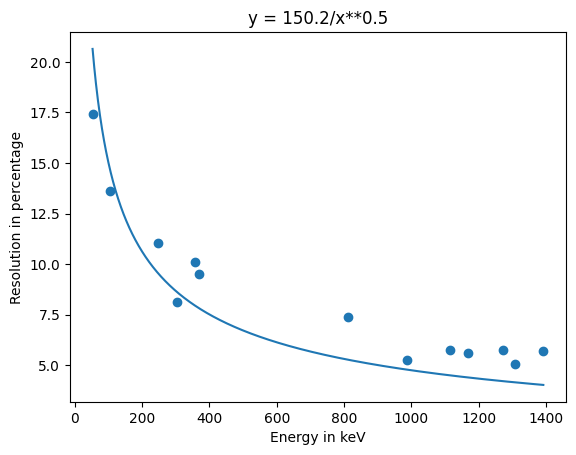

In [366]:
all_resolutions = np.array(total_peakinfo)[:,1]
plt.scatter(all_energies, all_resolutions)
popt, pcov = curve_fit(InverseRoot, all_energies, all_resolutions)
print("y = "+str(popt[0])[:5]+"/x**0.5")
x = np.linspace(int(np.min(all_energies)), int(np.max(all_energies)), int(np.max(all_energies)-np.min(all_energies)))
plt.plot(x, InverseRoot(x, *popt))
plt.ylabel("Resolution in percentage")
plt.xlabel("Energy in keV")
plt.title("y = "+str(popt[0])[:5]+"/x**0.5")
plt.show()

In [371]:
data = []
data.append(all_energies)
data.append(all_resolutions)
left = ["Energies in keV", "Resolutions in percentage"]
top = ["Co-60","Co-60","Eu-152","Eu-152","Eu-152","Eu-152","Eu-152","Eu-152","Eu-152", "Na-22", "Ba-133","Ba-133","Ba-133"]
pd.DataFrame(data, index = left, columns=top)

,Co-60,Co-60,Eu-152,Eu-152,Eu-152,Eu-152,Eu-152,Eu-152,Eu-152,Na-22,Ba-133,Ba-133,Ba-133
Energies in keV,1167.569422,1308.773358,103.803113,246.492662,358.115402,812.810683,987.594602,1115.277247,1392.463749,1272.058805,53.323871,305.185607,369.631483
Resolutions in percentage,5.587093,5.070611,13.613931,11.048896,10.084982,7.410365,5.278111,5.736199,5.729037,5.734615,17.399290,8.148684,9.531231


Resolution should be proportional to the inverse square root of energy for purely Poission statistics. Non-proportionality can possibly explain the worse resolution above the fitted inverse square root curve higher than 600 keV.

y = -0.36*x + 4.357


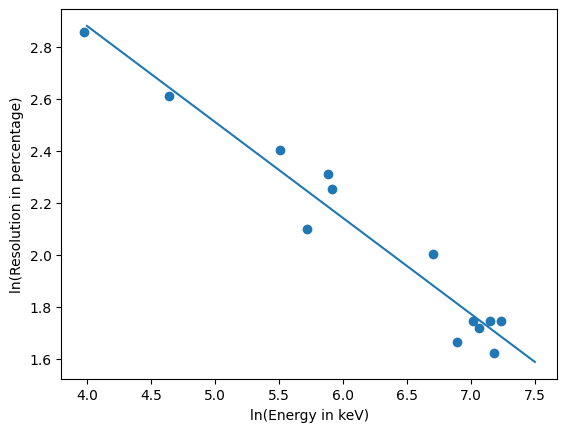

In [360]:
plt.scatter(np.log(all_energies), np.log(all_resolutions))
popt, pcov = curve_fit(Linear, np.log(all_energies), np.log(all_resolutions))
print("y = "+str(popt[0])[:5]+"*x + "+str(popt[1])[:5])
x = np.linspace(4, 7.5, 100)
plt.plot(x, Linear(x, *popt))
plt.ylabel("ln(Resolution in percentage)")
plt.xlabel("ln(Energy in keV)")
plt.show()